In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "12"

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

2024-06-24 15:41:08.777890: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
from utils import (
    create_plot,
    forecast_accuracy
)

In [6]:
# Check everything with Tensorflow works 
import sys

# import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
# print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
# tf.keras.utils.set_random_seed(5)
# tf.config.experimental.enable_op_determinism()

Python Platform: macOS-10.16-x86_64-i386-64bit
Tensor Flow Version: 2.12.0

Python 3.9.18 (main, Sep 11 2023, 08:20:50) 
[Clang 14.0.6 ]
Pandas 2.2.1
Scikit-Learn 1.4.1.post1
SciPy 1.12.0
GPU is available


In [7]:
tf.keras.utils.set_random_seed(10)
tf.config.experimental.enable_op_determinism()

### Loading the Dataset

In [8]:
ts_prices_btc = pd.read_csv("Data/Time_Series/prices/bitcoin_19_22.csv",index_col='date',parse_dates=['date'])

In [9]:
crypto = 'crypto_bitcoin'
# crypto = 'crypto_ethereum'
# crypto = 'crypto_xrp'

### Vader

In [10]:
model ='VADER'
df= pd.read_csv(f"Data/Time_Series/{crypto}/{model}_sts_19_22.csv",index_col='posted_on',parse_dates=['posted_on'])

In [11]:
ts_prices_btc= ts_prices_btc.join(df)

In [12]:
# Remove Neutral Time Series
for c in ts_prices_btc.columns:
    if 'prop' in c.lower() or 'neutral' in c.lower() or 'mean' in c.lower():
        print(f"Dropping column {c}")
        ts_prices_btc.drop(c,axis=1,inplace=True)

Dropping column neutral_count
Dropping column mean_vader_score


In [13]:
ts_prices_btc.head(4) #.shape

,price,positive_count,negative_count,total_posts,total_words,total_stopwords,total_comments,average_word_length
date,,,,,,,,
2019-01-01,3692.53,41,3,63,8369,3054,989,5.488478
2019-01-02,3794.26,48,9,90,12730,4843,1150,5.805391
2019-01-03,3872.17,56,20,113,15544,5994,1784,5.870047
2019-01-04,3776.53,41,10,95,9832,3628,1388,5.753959


In [14]:
df = ts_prices_btc

### Adding Features

In [16]:
n_lags = 14
for lag in range(1, n_lags + 1):
    df[f'price_lag_{lag}'] = df['price'].shift(lag)

In [17]:
window_sizes = [7, 14, 30]  # Window sizes for moving averages
for window_size in window_sizes:
    df[f'price_ma_{window_size}'] = df['price_lag_1'].rolling(window=window_size).mean()

In [18]:
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

In [19]:
df.isna().sum()

price                   0
positive_count          0
negative_count          0
total_posts             0
total_words             0
total_stopwords         0
total_comments          0
average_word_length     0
price_lag_1             1
price_lag_2             2
price_lag_3             3
price_lag_4             4
price_lag_5             5
price_lag_6             6
price_lag_7             7
price_lag_8             8
price_lag_9             9
price_lag_10           10
price_lag_11           11
price_lag_12           12
price_lag_13           13
price_lag_14           14
price_ma_7              7
price_ma_14            14
price_ma_30            30
day_of_week             0
month                   0
year                    0
dtype: int64

In [20]:
df = df[30:]

In [21]:
test_split=round(len(df)*0.40)
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
val_split=round(len(df_for_testing)*0.50)
df_for_validation=df_for_testing[:-val_split]
df_for_testing=df[-val_split:]
print(f"Training Set: {df_for_training.shape}")
print(f"Validation Set: {df_for_validation.shape}")
print(f"Testing Set: {df_for_testing.shape}")

Training Set: (859, 28)
Validation Set: (286, 28)
Testing Set: (286, 28)


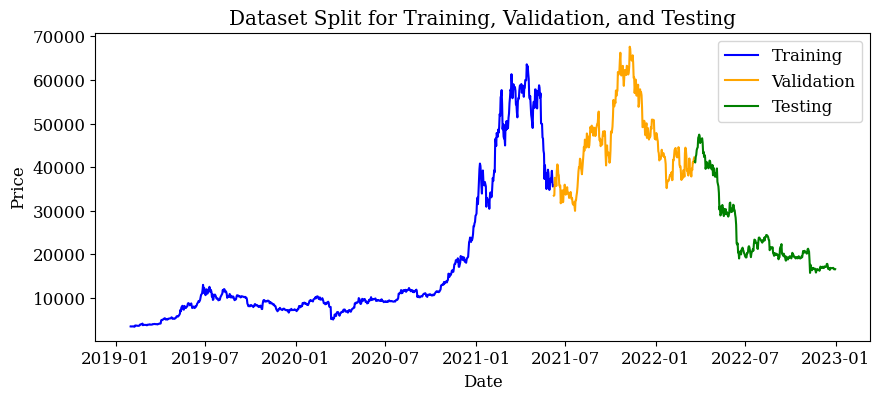

In [22]:
plt.figure(figsize=(10, 4))

plt.plot(df_for_training.index, df_for_training['price'], label='Training', color='blue')
plt.plot(df_for_validation.index, df_for_validation['price'], label='Validation', color='orange')
plt.plot(df_for_testing.index, df_for_testing['price'], label='Testing', color='green')

# Add title and labels
plt.title('Dataset Split for Training, Validation, and Testing')
plt.xlabel('Date')
plt.ylabel('Price')

# Add legend
plt.legend()

# Show plot
plt.show()

In [23]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_validation_scaled=scaler.transform(df_for_validation)
df_for_training_scaled.shape, df_for_validation_scaled.shape

((859, 28), (286, 28))

In [24]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,30)
valX,valY=createXY(df_for_validation_scaled,30)

In [25]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(30,return_sequences=True,input_shape=(30,27)))
    grid_model.add(LSTM(30))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(valX,valY))
parameters = {'batch_size' : [16,20],
            'epochs' : [8,10],
            'optimizer' : ['adam'] }
grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

/var/folders/2l/h6ht9_t96fn33pfzbxcdp_dm0000gn/T/ipykernel_34659/1645025208.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(valX,valY))


In [26]:
grid_search = grid_search.fit(trainX,trainY)

2024-06-24 15:41:13.174313: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-24 15:41:13.174372: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-06-24 15:41:13.839836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:41:13.841488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] 

Epoch 1/8


2024-06-24 15:41:14.464570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:41:14.466209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:41:14.467349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0349

2024-06-24 15:41:20.034364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:41:20.034729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:41:20.283465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - 7s 97ms/step - loss: 0.0349 - val_loss: 0.0085
Epoch 2/8
26/26 [==============================] - 1s 40ms/step - loss: 0.0079 - val_loss: 0.0070
Epoch 3/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0061 - val_loss: 0.0074
Epoch 4/8
26/26 [==============================] - 1s 41ms/step - loss: 0.0050 - val_loss: 0.0098
Epoch 5/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0048 - val_loss: 0.0067
Epoch 6/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0040 - val_loss: 0.0072
Epoch 7/8
26/26 [==============================] - 1s 41ms/step - loss: 0.0037 - val_loss: 0.0087
Epoch 8/8
26/26 [==============================] - 1s 41ms/step - loss: 0.0037 - val_loss: 0.0195


2024-06-24 15:41:28.495950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:41:28.496324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:41:28.694816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - 1s 18ms/step - loss: 0.0011


2024-06-24 15:41:30.177050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:41:30.178709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:41:30.179781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-24 15:41:30.461388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:41:30.461836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:41:30.697794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - ETA: 0s - loss: 0.0030

2024-06-24 15:41:35.665517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:41:35.665907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:41:35.863381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - 6s 92ms/step - loss: 0.0030 - val_loss: 0.2000
Epoch 2/8
26/26 [==============================] - 1s 49ms/step - loss: 7.0090e-04 - val_loss: 0.1655
Epoch 3/8
26/26 [==============================] - 1s 41ms/step - loss: 4.2139e-04 - val_loss: 0.1756
Epoch 4/8
26/26 [==============================] - 1s 41ms/step - loss: 3.7634e-04 - val_loss: 0.1601
Epoch 5/8
26/26 [==============================] - 1s 40ms/step - loss: 3.6470e-04 - val_loss: 0.1624
Epoch 6/8
26/26 [==============================] - 1s 42ms/step - loss: 3.1619e-04 - val_loss: 0.1797
Epoch 7/8
26/26 [==============================] - 1s 42ms/step - loss: 2.8592e-04 - val_loss: 0.1694
Epoch 8/8
26/26 [==============================] - 1s 42ms/step - loss: 2.5512e-04 - val_loss: 0.1900


2024-06-24 15:41:44.556844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:41:44.557215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:41:44.748599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - 1s 16ms/step - loss: 0.0709


2024-06-24 15:41:46.143497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:41:46.145002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:41:46.146037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-24 15:41:46.346077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:41:46.348456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:41:46.350007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0351

2024-06-24 15:41:51.346056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:41:51.346411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:41:51.529772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - 6s 86ms/step - loss: 0.0351 - val_loss: 0.0146
Epoch 2/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0108 - val_loss: 0.0153
Epoch 3/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0075 - val_loss: 0.0145
Epoch 4/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0058 - val_loss: 0.0172
Epoch 5/10
26/26 [==============================] - 2s 68ms/step - loss: 0.0053 - val_loss: 0.0165
Epoch 6/10
26/26 [==============================] - 2s 97ms/step - loss: 0.0051 - val_loss: 0.0176
Epoch 7/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0047 - val_loss: 0.0185
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0047 - val_loss: 0.0337
Epoch 9/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0057 - val_loss: 0.0261
Epoch 10/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0041 - val_loss: 0.0255


2024-06-24 15:42:03.689349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:42:03.689715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:42:03.892571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - 2s 16ms/step - loss: 8.4140e-04


2024-06-24 15:42:05.820571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:42:05.822091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:42:05.823121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-24 15:42:06.098311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [415,30,27]
	 [[{{node Placeholder/_10}}]]
2024-06-24 15:42:06.098700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:42:06.294108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

26/26 [==============================] - ETA: 0s - loss: 0.0069

2024-06-24 15:42:11.128931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [256,30,27]
	 [[{{node Placeholder/_10}}]]
2024-06-24 15:42:11.129287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:42:11.310938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

26/26 [==============================] - 6s 91ms/step - loss: 0.0069 - val_loss: 0.2889
Epoch 2/10
26/26 [==============================] - 2s 62ms/step - loss: 0.0012 - val_loss: 0.1832
Epoch 3/10
26/26 [==============================] - 1s 40ms/step - loss: 5.3983e-04 - val_loss: 0.1301
Epoch 4/10
26/26 [==============================] - 1s 38ms/step - loss: 4.5822e-04 - val_loss: 0.1008
Epoch 5/10
26/26 [==============================] - 1s 41ms/step - loss: 4.6598e-04 - val_loss: 0.1071
Epoch 6/10
26/26 [==============================] - 1s 46ms/step - loss: 3.8038e-04 - val_loss: 0.1051
Epoch 7/10
26/26 [==============================] - 1s 41ms/step - loss: 3.5214e-04 - val_loss: 0.0946
Epoch 8/10
26/26 [==============================] - 1s 44ms/step - loss: 3.2672e-04 - val_loss: 0.1057
Epoch 9/10
26/26 [==============================] - 1s 42ms/step - loss: 3.0735e-04 - val_loss: 0.1050
Epoch 10/10
26/26 [==============================] - 1s 42ms/step - loss: 2.7039e-04 - val_l

2024-06-24 15:42:22.607955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:42:22.608335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:42:22.833388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - 1s 15ms/step - loss: 0.0413


2024-06-24 15:42:24.272462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:42:24.273945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:42:24.275201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-24 15:42:24.479935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:42:24.481487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:42:24.482562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0471

2024-06-24 15:42:29.910063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:42:29.910428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:42:30.819449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

21/21 [==============================] - 7s 153ms/step - loss: 0.0471 - val_loss: 0.0316
Epoch 2/8
21/21 [==============================] - 1s 42ms/step - loss: 0.0102 - val_loss: 0.0203
Epoch 3/8
21/21 [==============================] - 1s 42ms/step - loss: 0.0072 - val_loss: 0.0290
Epoch 4/8
21/21 [==============================] - 1s 42ms/step - loss: 0.0067 - val_loss: 0.0308
Epoch 5/8
21/21 [==============================] - 1s 44ms/step - loss: 0.0056 - val_loss: 0.0104
Epoch 6/8
21/21 [==============================] - 1s 45ms/step - loss: 0.0059 - val_loss: 0.0120
Epoch 7/8
21/21 [==============================] - 1s 42ms/step - loss: 0.0048 - val_loss: 0.0288
Epoch 8/8
 9/21 [===========>..................] - ETA: 0s - loss: 0.0033   

2024-06-24 15:42:38.231297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:42:38.231671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]


21/21 [==============================] - 0s 19ms/step - loss: 0.0032


2024-06-24 15:42:38.911871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:42:38.913916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:42:38.915557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-24 15:42:39.115059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:42:39.116581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:42:39.117671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0037

2024-06-24 15:42:44.531754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:42:44.532197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:42:44.756036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

21/21 [==============================] - 7s 122ms/step - loss: 0.0037 - val_loss: 0.3935
Epoch 2/8
21/21 [==============================] - 1s 44ms/step - loss: 0.0010 - val_loss: 0.2500
Epoch 3/8
21/21 [==============================] - 2s 78ms/step - loss: 5.9528e-04 - val_loss: 0.2556
Epoch 4/8
21/21 [==============================] - 1s 42ms/step - loss: 4.9724e-04 - val_loss: 0.2563
Epoch 5/8
21/21 [==============================] - 1s 46ms/step - loss: 4.3864e-04 - val_loss: 0.2347
Epoch 6/8
21/21 [==============================] - 1s 50ms/step - loss: 4.3812e-04 - val_loss: 0.2534
Epoch 7/8
21/21 [==============================] - 1s 70ms/step - loss: 3.5637e-04 - val_loss: 0.2218
Epoch 8/8
 9/21 [===========>..................] - ETA: 0s - loss: 5.3919e-04

2024-06-24 15:42:54.519795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:42:54.520219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]


21/21 [==============================] - 0s 17ms/step - loss: 0.0914


2024-06-24 15:42:55.115363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:42:55.117157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:42:55.118253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-24 15:42:55.331065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:42:55.332887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:42:55.334155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0752

2024-06-24 15:43:02.320468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:02.320831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:03.317673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

21/21 [==============================] - 9s 166ms/step - loss: 0.0752 - val_loss: 0.0230
Epoch 2/10
21/21 [==============================] - 1s 42ms/step - loss: 0.0104 - val_loss: 0.0067
Epoch 3/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 4/10
21/21 [==============================] - 1s 43ms/step - loss: 0.0068 - val_loss: 0.0125
Epoch 5/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0049 - val_loss: 0.0199
Epoch 6/10
21/21 [==============================] - 1s 42ms/step - loss: 0.0050 - val_loss: 0.0157
Epoch 7/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0043 - val_loss: 0.0234
Epoch 8/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0047 - val_loss: 0.0174
Epoch 9/10
21/21 [==============================] - 1s 45ms/step - loss: 0.0044 - val_loss: 0.0194
Epoch 10/10
10/21 [=============>................] - ETA: 0s - loss: 6.1240e-04

2024-06-24 15:43:12.667557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:12.667920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]


21/21 [==============================] - 0s 17ms/step - loss: 4.9297e-04


2024-06-24 15:43:13.255418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:43:13.257174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:43:13.258442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-24 15:43:13.547060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:13.547455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:14.660710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

21/21 [==============================] - ETA: 0s - loss: 0.0020

2024-06-24 15:43:19.475835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:19.476206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:19.665836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

21/21 [==============================] - 7s 115ms/step - loss: 0.0020 - val_loss: 0.1942
Epoch 2/10
21/21 [==============================] - 1s 42ms/step - loss: 5.7147e-04 - val_loss: 0.1793
Epoch 3/10
21/21 [==============================] - 1s 42ms/step - loss: 4.1638e-04 - val_loss: 0.1729
Epoch 4/10
21/21 [==============================] - 1s 43ms/step - loss: 3.9083e-04 - val_loss: 0.1817
Epoch 5/10
21/21 [==============================] - 1s 42ms/step - loss: 3.8243e-04 - val_loss: 0.1971
Epoch 6/10
21/21 [==============================] - 1s 41ms/step - loss: 2.9951e-04 - val_loss: 0.1944
Epoch 7/10
21/21 [==============================] - 1s 42ms/step - loss: 2.9142e-04 - val_loss: 0.2027
Epoch 8/10
21/21 [==============================] - 1s 47ms/step - loss: 2.7906e-04 - val_loss: 0.2014
Epoch 9/10
21/21 [==============================] - 3s 126ms/step - loss: 2.4640e-04 - val_loss: 0.2174
Epoch 10/10
10/21 [=============>................] - ETA: 0s - loss: 4.0433e-04

2024-06-24 15:43:30.501126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:30.501503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]


21/21 [==============================] - 1s 34ms/step - loss: 0.0798


2024-06-24 15:43:31.642573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:43:31.645322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:43:31.647335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-24 15:43:31.878272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:43:31.879906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:43:31.881011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

52/52 [==============================] - ETA: 0s - loss: 0.0146

2024-06-24 15:44:03.797416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:03.797829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:04.029858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

52/52 [==============================] - 34s 100ms/step - loss: 0.0146 - val_loss: 0.0131
Epoch 2/10
52/52 [==============================] - 2s 41ms/step - loss: 0.0041 - val_loss: 0.0183
Epoch 3/10
52/52 [==============================] - 2s 35ms/step - loss: 0.0034 - val_loss: 0.0068
Epoch 4/10
52/52 [==============================] - 2s 35ms/step - loss: 0.0030 - val_loss: 0.0093
Epoch 5/10
52/52 [==============================] - 2s 35ms/step - loss: 0.0024 - val_loss: 0.0256
Epoch 6/10
52/52 [==============================] - 2s 35ms/step - loss: 0.0021 - val_loss: 0.0159
Epoch 7/10
52/52 [==============================] - 2s 35ms/step - loss: 0.0027 - val_loss: 0.0224
Epoch 8/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0020 - val_loss: 0.0129
Epoch 9/10
52/52 [==============================] - 2s 38ms/step - loss: 0.0016 - val_loss: 0.0188
Epoch 10/10
52/52 [==============================] - 2s 40ms/step - loss: 0.0016 - val_loss: 0.0109


In [27]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}

In [28]:
my_model_all=grid_search.best_estimator_.model

In [29]:
df.shape

(1431, 28)

In [30]:
df_for_validation[-30:].shape, df_for_validation[-30:].index[0]

((30, 28), Timestamp('2022-02-19 00:00:00'))

In [31]:
df_for_testing = pd.concat([df_for_validation[-30:],df_for_testing])

In [32]:
df_for_testing.shape

(316, 28)

In [34]:
df_for_testing_scaled = scaler.transform(df_for_testing)
testX,testY=createXY(df_for_testing_scaled,30)
pred = my_model_all.predict(testX)
prediction_copies_array = np.repeat(pred,28, axis=-1)
predicted_prices = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(pred),28)))[:,0]

2024-06-24 15:45:14.995270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [286,30,27]
	 [[{{node Placeholder/_10}}]]
2024-06-24 15:45:14.995752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [286,30,27]
	 [[{{node Placeholder/_10}}]]
2024-06-24 15:45:15.360611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2

9/9 [==============================] - 2s 28ms/step


In [35]:
predicted_prices.shape

(286,)

In [36]:
df_for_testing[30:].shape

(286, 28)

In [37]:
n_df= pd.DataFrame()
n_df.index = df_for_testing.index[30:]
n_df['price'] = predicted_prices

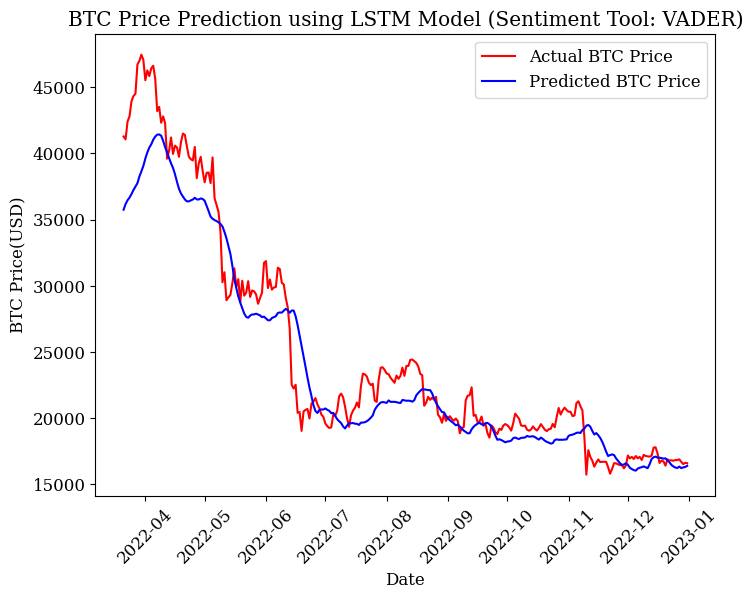

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(df_for_testing['price'].iloc[30:], color = 'red', label = 'Actual BTC Price')
plt.plot(n_df['price'], color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction using LSTM Model (Sentiment Tool: VADER)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('BTC Price(USD)')
plt.legend()
plt.show()

In [39]:
res = forecast_accuracy(n_df['price'], df_for_testing['price'].iloc[30:],['VADER'])
res

,MAE,MAPE,MSE,RMSE
VADER,1866.894148,7.029592,6.513859e+06,2552.226232


In [40]:
my_model_all.save("BTC_ModelC.keras")
